# Circuitos cuánticos para la codificación por bloques
Muchos problemas de álgebra lineal pueden resolverse en una computadora cuántica mediante el uso de algoritmos cuánticos modernos que hacen uso de codificaciones por bloques. Esto a su vez permite resolver problemas de interés en computación cuántica, que van desde sistemas lineales hasta caminatas cuánticas, simulación de Hamiltonianos y aprendizaje automático cuántico. 

Entenderemos por *codificación por bloques* a la incorporación de una matriz de interés $A$, no necesariamente unitaria, en una transfomación unitaria de mayor dimensión $U_A$, descomponible en un producto de transformaciones unitarias simples y aptas para ser procesadas eficientemente en un computador cuántico.

En el presente artículo educativo, sentaremos las bases matemáticas e implementaremos un enfoque de construcción explícita de circuitos cuánticos eficientes para afrontar la codificación por bloques. En este sentido, deduciremos la estructura de los *oráculos* necesarios y suficente estos algoritmos de codificación de matrices dispersas generales.
## Introducción
Se define la codificación por bloques como el método de adición de una matriz no unitaria $A \in \mathbb{C}^{N \times N}$ dentro de una matriz unitaria $U_A$ de la forma:

\begin{equation}
U_A=
\begin{bmatrix}
A & * \\
* & *
\end{bmatrix}
\end{equation}

Donde $*$ denota algún bloque de matriz. En particular, al aplicar $U_A$ a un vector de la forma:

\begin{equation}
v =
\begin{bmatrix}
x \\
0
\end{bmatrix}
=|0\rangle |x\rangle
\end{equation}

Tenemos:

\begin{equation}
w = U_A v = 
\begin{bmatrix}
Ax \\
*
\end{bmatrix}
=|0\rangle (A|x\rangle) +|1\rangle |*\rangle
\end{equation}

Donde $|*\rangle$ no es un vector de interés. Note que siempre que el primer qubit se encuentre en el estado $|0\rangle$ al ser medido, el registro del segundo qubit contendrá $A|x\rangle$. 

Una propiedad importante es que $A$ esté *adecuadamente escalada*, esto es, $\lVert A \lVert _2 \leq 1$. De no cumplirse esta condición de escalamiento, no se garantiza la existencia de una codificación en bloque de A.

>**Definición (codificación en bloque):** Dada una matriz de $n$ qubits $A  (N = 2^n)$, si existen $\alpha, \epsilon \in \mathbb{R}_{+}$ y una matriz unitaria de $n+m$ qubits $U_A$ tal que:

\begin{equation}
 \lVert A-\alpha(\langle 0^m|\otimes I_{N})U_A \left( |0^m\rangle \otimes I_{N} \right) \lVert _{2} \leq \epsilon
\end{equation}

>Entonces $U_A$ se conoce como un $(\alpha,m,\epsilon)$-codificación-en-bloque de $A$. En particular, cuando la codificación es exacta ($\epsilon = 0$), $U_A$ se denomina una $(\alpha,m)$-codificación-en-bloque de $A$.

En este sentido, $m$ se conoce como el número de *qubits ancilla* usados para codificar en bloque a $A$, tanto que $(\langle 0^m|\otimes I_{N})U_A(|0^m\rangle \otimes I_{N})$ debe ser interpretado como el bloque izquierdo superior de orden $2^n$ de $U_A$. 

Por otro lado $(\alpha,m)$ son tal que:
- $\alpha$ se denomina *factor de subnormalización*, necesario para codificar matrices de norma espectral arbitraria.
- $m$ es el número de qubits ancilla usado en la codificación por bloques.
> **Teorema (condición de codificación):** Sea $c(j,l)$ una función que proporciona el índice de la fila del $l$-ésimo elemento no nulo en la $j$-ésima columna de una matriz $s$-dispersa $A\in \mathbb{C}^{N\times N}$, con $N=2^n$ y $s=2^m$. Si existe un operador unitario $O_c$ tal que:

\begin{equation}
O_{c}|l\rangle |j\rangle = |l\rangle |c(j,l)\rangle
\end{equation}

>Y una transformación unitaria $O_A$ tal que:

\begin{equation}
O_A |0\rangle |l\rangle |j\rangle = \left( A_{c(j,l),j}|0\rangle+\sqrt{1-\lvert A_{c(j,l),j}\lvert ^2}|1\rangle \right) |l\rangle |j\rangle
\end{equation}

>Entonces

\begin{equation}
U_A=\left(I_2\otimes D_s \otimes I_N \right)\left(I_2\otimes O_c\right)O_A\left(I_2 \otimes D_s\otimes I_N\right)
\end{equation}

>Codifica en bloque a $A/s$, donde $D_s$ se conoce como *operador difusión*. A saber:

\begin{equation}
D_s = H^{\otimes m}
\end{equation}

>Note que $O_c$ es unitario, esto es:

\begin{equation}
O_{c}^{\dag}|l\rangle |c(j,l)\rangle = |l\rangle |j\rangle
\end{equation}

>Que implica que por cada fila indexada según $i=c(j,l)$, podemos recuperar el índice de la columna $j$ dado un valor de $l$.

En efecto, atendiendo a que, para $A$ codificable en bloque:

\begin{equation}
[ A ]_{ij} =[ (\langle 0^m|\otimes I _{N})U_A(|0^m\rangle \otimes I_{N}) ]_{ij}
\end{equation}




Importamos las librerías necesarias para la construcción de nuestro circuito de interés. A saber:

In [18]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit.library import XGate,ZGate, RYGate
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit import execute, Aer
import numpy as np

Definimos una función para identificar las posiciones de las entradas de la matriz $A$ (remarcaje) a codificar en bloque, en base binaria. Esta función será utilizada recurrentemente, pues será de vital importancia para particularizar cada rotación uniformemente controlada, al corresponder los ángulos $\theta_{i(l),j(l)}$ con las entradas de $A$, $a_{ij}$, según como convino anteriormente.

In [19]:
def aij(l, e):
    binstr = format(l, '0' + str(e) + 'b')
    bininv= binstr[::-1]
    return bininv

Procedemos a introducir los parámetros de interés. A saber:
- $n$: dimensión del espacio de estados, $\mathcal{H}_{n}$.
- $e$: dimensión del espacio de Hilbert extendido $\mathcal{H}$, esto es, incluidas las ancillas $(\mathcal{H} = \mathcal{H}_{n}+\mathcal{H}_{a})$


In [20]:
n = 2
e = 2*n
qr = QuantumRegister(2*n+1)
qc = QuantumCircuit(qr)
Hanc = range(1, n + 1)
qc.h(Hanc)
qc.barrier()

Observe que se está inicializando un registro cuántico de $2n+1$ qubits, el cual proviene de la dimensión de $\mathcal{H}$ y el qubit *comodín* que sirve para definir a $O_A$. Asimismo, note con <code>```Hanc = range(1,n+1)```</code> se está introduciendo el efecto de $H^{\otimes n}$ sobre los qubits ancilla. Seguido de ello, implementamos:

In [21]:
Hmat = np.array([[1, 1], [1, -1]])
Hprod = Hmat
n = 2
for i in range(1,2*n):
    Hprod = np.kron(Hprod, Hmat)

In [22]:
nA = 2**n
A = np.random.rand(nA,nA)
acA = np.arccos(A)
theta = acA.ravel()

In [23]:
newtheta = np.linalg.solve(Hprod, theta)

In [24]:
x = list(range(1,2*n+1))
x.extend([0])
for i in range(2**(2*n)):
    ry_gate = RYGate(newtheta[i])
    resultado = aij(i, 2*n)
    qc.append(ry_gate.control(2*n, ctrl_state=resultado), x)
qc.barrier()

Donde se incorporan las rotaciones uniformemente controladas como compuertas multi-qubits adecuadamente identificadas con el remarcaje de las entradas de la matriz a codificar, en binario. Finalmente:

In [25]:
for i in range(1,n+1):
    for j in range(n+1,2*n+1):
        qc.swap(i,j)
qc.barrier()
qc.h(Hanc)

Lo cual corresponde a la sucesión final de compuertas *SWAP* así como se requiere finalmente en la definición de $U_A$, seguido de una nueva sucesión de $H^{\otimes n}$ sobre los qubits ancilla.

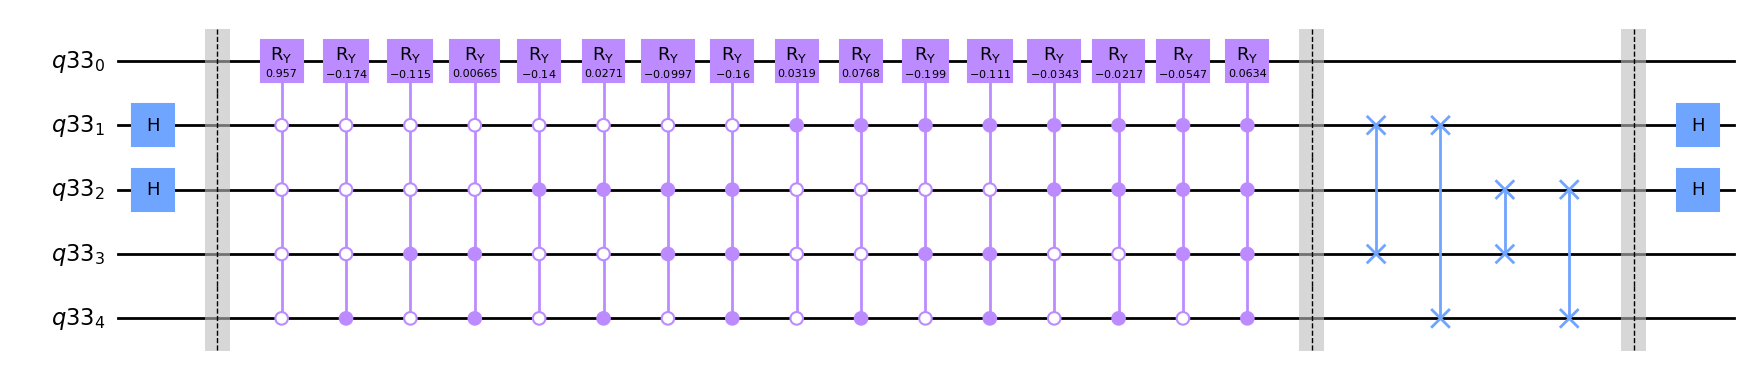

In [26]:
qc.draw(output='mpl')